In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

import matplotlib.pyplot as plt

import ase.io

from utils.soap import compute_spherical_expansion_librascal, PowerSpectrum
from utils.gap import train_gap_model
from utils.alchemical import AlchemicalCombine

torch.set_default_dtype(torch.float64)

In [2]:
frames = ase.io.read("data/elpasolites_10590.xyz", ":300")
energies = torch.tensor(np.loadtxt("data/elpasolites_10590_evpa.dat")[:300])

train_frames = frames[:250]
test_frames = frames[250:]

train_energies = energies[:250]
test_energies = energies[250:]

In [3]:
global_species = set()
for frame in frames:
    global_species.update(frame.numbers)

global_species = list(map(lambda u: int(u), global_species))

HYPERS = {
    "interaction_cutoff": 5.0,
    "max_angular": 4,
    "max_radial": 4,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "compute_gradients": False,
    "expansion_by_species_method": "user defined",
    "global_species": global_species,
}

In [4]:
train_spherical_expansions, train_slices = compute_spherical_expansion_librascal(train_frames, HYPERS)
test_spherical_expansions, test_slices = compute_spherical_expansion_librascal(test_frames, HYPERS)

train_species = torch.hstack([torch.tensor(frame.numbers) for frame in train_frames])
test_species = torch.hstack([torch.tensor(frame.numbers) for frame in test_frames])

# Baseline: standard GAP model

In [5]:
class BaseGap(torch.nn.Module):
    def __init__(self, n_support, zeta, lambdas):
        super().__init__()
        self.power_spectrum = PowerSpectrum()

        self.n_support = n_support
        self.zeta = zeta
        self.lambdas = lambdas

        self.model = None

    def fit(self, spherical_expansion, all_species, structures_slices, energies):
        power_spectrum = self.power_spectrum(spherical_expansion)

        self.model = train_gap_model(
            power_spectrum, 
            all_species,
            structures_slices,
            energies, 
            self.n_support, 
            zeta=self.zeta, 
            lambdas=self.lambdas
        )

    def forward(self, spherical_expansion, all_species, structures_slices):
        ps = self.power_spectrum(spherical_expansion)
        return self.model(ps, all_species, structures_slices)

In [6]:
n_support = {
    species: 3 for species in global_species
}

base_model = BaseGap(n_support, zeta=2, lambdas=[1e-6, 1e-6])
base_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)

In [7]:
loss_fn = torch.nn.MSELoss()

predicted_energies_training_set = base_model(
    train_spherical_expansions, train_species, train_slices
)

predicted_energies_test_set = base_model(
    test_spherical_expansions, test_species, test_slices
)

train_loss = loss_fn(predicted_energies_training_set.squeeze(), train_energies)
test_loss = loss_fn(predicted_energies_test_set.squeeze(), test_energies)

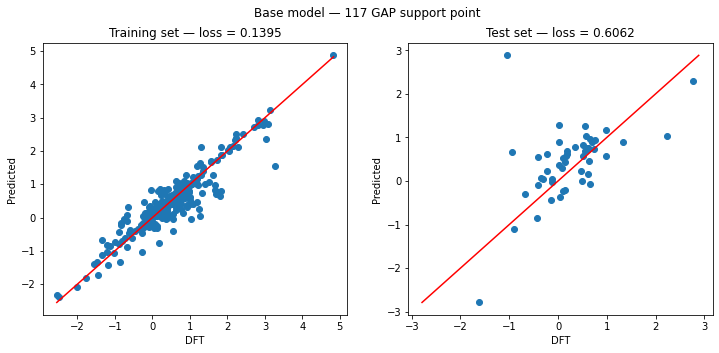

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(train_energies, predicted_energies_training_set.numpy())
x = np.linspace(train_energies.min(), train_energies.max(), 20)
ax[0].plot(x, x, color='r')

ax[0].set_title(f'Training set — loss = {train_loss:.4}')
ax[0].set_xlabel('DFT')
ax[0].set_ylabel('Predicted')


ax[1].scatter(predicted_energies_test_set.numpy(), test_energies)
x = np.linspace(test_energies.min(), test_energies.max(), 20)
ax[1].plot(x, x, color='r')

ax[1].set_title(f'Test set — loss = {test_loss:.4}')
ax[1].set_xlabel('DFT')
ax[1].set_ylabel('Predicted')

fig.suptitle(f"Base model — {sum(v for v in n_support.values())} GAP support point")
fig.savefig("base-model.pdf", bbox_inches="tight")

# Combining species

In [9]:
class MixedSpeciesGap(torch.nn.Module):
    def __init__(self, species, n_pseudo_species, n_support, zeta, lambdas, optimizable_weights):
        super().__init__()
        self.power_spectrum = PowerSpectrum()
        self.alchemical = AlchemicalCombine(species, n_pseudo_species)

        self.n_support = n_support
        self.zeta = zeta
        self.lambdas = lambdas

        self.optimizable_weights = optimizable_weights
        self.model = None

    def fit(self, spherical_expansion, all_species, structures_slices, energies):
        combined = self.alchemical(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)
        
        self.model = train_gap_model(
            power_spectrum, 
            all_species,
            structures_slices,
            energies, 
            self.n_support, 
            zeta=self.zeta, 
            lambdas=self.lambdas,
            optimizable_weights=self.optimizable_weights,
        )

    def forward(self, spherical_expansion, all_species, structures_slices):
        combined = self.alchemical(spherical_expansion)
        ps = self.power_spectrum(combined)
        return self.model(ps, all_species, structures_slices)

In [10]:
N_PSEUDO_SPECIES = 2

mixed_species_model = MixedSpeciesGap(
    global_species, 
    n_pseudo_species=N_PSEUDO_SPECIES, 
    n_support=n_support, 
    zeta=2, 
    lambdas=[1e-6, 1e-6],
    optimizable_weights=False,
)
mixed_species_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)

In [11]:
predicted_energies_training_set = mixed_species_model(
    train_spherical_expansions, train_species, train_slices
).detach()

predicted_energies_test_set = mixed_species_model(
    test_spherical_expansions, test_species, test_slices
).detach()

train_loss = loss_fn(predicted_energies_training_set.squeeze(), train_energies)
test_loss = loss_fn(predicted_energies_test_set.squeeze(), test_energies)

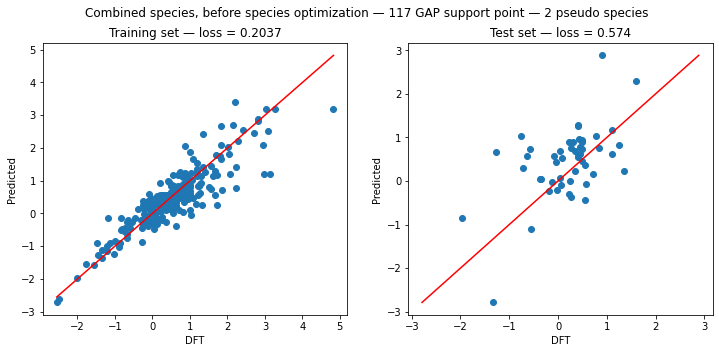

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(train_energies, predicted_energies_training_set.numpy())
x = np.linspace(train_energies.min(), train_energies.max(), 20)
ax[0].plot(x, x, color='r')

ax[0].set_title(f'Training set — loss = {train_loss:.4}')
ax[0].set_xlabel('DFT')
ax[0].set_ylabel('Predicted')


ax[1].scatter(predicted_energies_test_set.numpy(), test_energies)
x = np.linspace(test_energies.min(), test_energies.max(), 20)
ax[1].plot(x, x, color='r')

ax[1].set_title(f'Test set — loss = {test_loss:.4}')
ax[1].set_xlabel('DFT')
ax[1].set_ylabel('Predicted')

fig.suptitle(f"Combined species, before species optimization — {sum(v for v in n_support.values())} GAP support point — {N_PSEUDO_SPECIES} pseudo species")
fig.savefig("species-before.pdf", bbox_inches="tight")

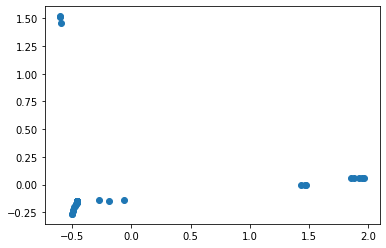

In [13]:
species_combining_matrix = mixed_species_model.alchemical.combining_matrix.detach().numpy()

plt.scatter(species_combining_matrix[:, 0], species_combining_matrix[:, 1])

# Optimization loop for the species projection only

In [14]:
mixed_species_model = MixedSpeciesGap(
    global_species, 
    n_pseudo_species=N_PSEUDO_SPECIES, 
    n_support=n_support, 
    zeta=2, 
    lambdas=[1e-6, 1e-6],
    optimizable_weights=False,
)
mixed_species_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)

optimizer = torch.optim.AdamW(mixed_species_model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()

for epoch in range(20):
    optimizer.zero_grad()

    mixed_species_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)
    predicted = mixed_species_model(
        train_spherical_expansions, train_species, train_slices
    )    

    loss = loss_fn(predicted.squeeze(), train_energies)

    if epoch % 1 == 0:
        print(epoch, loss.item())

    loss.backward()
    optimizer.step()


0 0.2036514856104529
1 0.18102953964836974
2 0.1687096910697489
3 0.19084349811365162
4 0.15325410350817592
5 0.13278699070833622
6 0.12333257792581347
7 0.11014763414561068
8 0.11821695307630453
9 0.12679730155588384
10 0.12435948326889354
11 0.13941635388282372
12 0.13476816479267906
13 0.1030132669633762
14 0.10457992620698474
15 0.09827222082406877
16 0.09568260705136794
17 0.10353255683355227
18 0.09545655502560282
19 0.08889333086178013


In [15]:
predicted_energies_training_set = mixed_species_model(
    train_spherical_expansions, train_species, train_slices
).detach()

predicted_energies_test_set = mixed_species_model(
    test_spherical_expansions, test_species, test_slices
).detach()

train_loss = loss_fn(predicted_energies_training_set.squeeze(), train_energies)
test_loss = loss_fn(predicted_energies_test_set.squeeze(), test_energies)

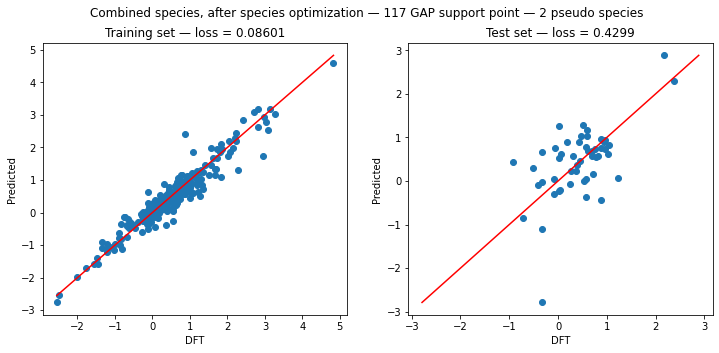

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(train_energies, predicted_energies_training_set.numpy())
x = np.linspace(train_energies.min(), train_energies.max(), 20)
ax[0].plot(x, x, color='r')

ax[0].set_title(f'Training set — loss = {train_loss:.4}')
ax[0].set_xlabel('DFT')
ax[0].set_ylabel('Predicted')


ax[1].scatter(predicted_energies_test_set.numpy(), test_energies)
x = np.linspace(test_energies.min(), test_energies.max(), 20)
ax[1].plot(x, x, color='r')

ax[1].set_title(f'Test set — loss = {test_loss:.4}')
ax[1].set_xlabel('DFT')
ax[1].set_ylabel('Predicted')

fig.suptitle(f"Combined species, after species optimization — {sum(v for v in n_support.values())} GAP support point — {N_PSEUDO_SPECIES} pseudo species")
fig.savefig("species-after.pdf", bbox_inches="tight")

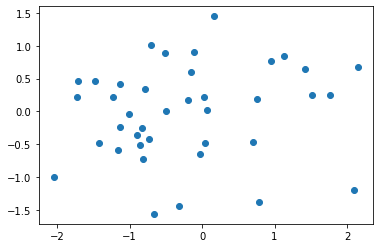

In [17]:
species_combining_matrix = mixed_species_model.alchemical.combining_matrix.detach().numpy()

plt.scatter(species_combining_matrix[:, 0], species_combining_matrix[:, 1])

# Optimization loop for both species and kernel weights

In [18]:
mixed_species_model = MixedSpeciesGap(
    global_species, 
    n_pseudo_species=N_PSEUDO_SPECIES, 
    n_support=n_support, 
    zeta=2, 
    lambdas=[1e-6, 1e-6],
    optimizable_weights=True,
)
mixed_species_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)


optimizer = torch.optim.AdamW(mixed_species_model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()

for epoch in range(20):
    optimizer.zero_grad()

    predicted = mixed_species_model(
        train_spherical_expansions, train_species, train_slices
    )    

    loss = loss_fn(predicted.squeeze(), train_energies)

    if epoch % 1 == 0:
        print(epoch, loss.item())

    loss.backward()
    optimizer.step()

0 0.20365148561045293
1 0.17428357038919948
2 0.21918935801518585
3 0.13922764290103476
4 0.15929243451941572
5 0.1461639276320409
6 0.12155320283114397
7 0.10947686020300865
8 0.10913406685898681
9 0.10782528485452623
10 0.100284810092909
11 0.09103447399620247
12 0.08563364314039222
13 0.08389735868608422
14 0.08114130831598287
15 0.07632256957373941
16 0.07197144965960146
17 0.06934000129034824
18 0.06678508016847624
19 0.06361868420976242


In [19]:
predicted_energies_training_set = mixed_species_model(
    train_spherical_expansions, train_species, train_slices
).detach()

predicted_energies_test_set = mixed_species_model(
    test_spherical_expansions, test_species, test_slices
).detach()

train_loss = loss_fn(predicted_energies_training_set.squeeze(), train_energies)
test_loss = loss_fn(predicted_energies_test_set.squeeze(), test_energies)

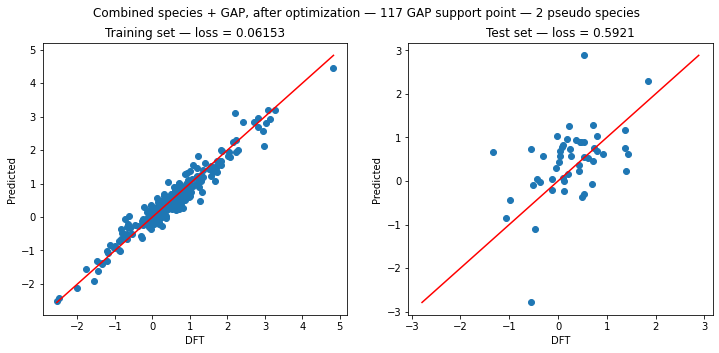

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(train_energies, predicted_energies_training_set.numpy())
x = np.linspace(train_energies.min(), train_energies.max(), 20)
ax[0].plot(x, x, color='r')

ax[0].set_title(f'Training set — loss = {train_loss:.4}')
ax[0].set_xlabel('DFT')
ax[0].set_ylabel('Predicted')


ax[1].scatter(predicted_energies_test_set.numpy(), test_energies)
x = np.linspace(test_energies.min(), test_energies.max(), 20)
ax[1].plot(x, x, color='r')

ax[1].set_title(f'Test set — loss = {test_loss:.4}')
ax[1].set_xlabel('DFT')
ax[1].set_ylabel('Predicted')

fig.suptitle(f"Combined species + GAP, after optimization — {sum(v for v in n_support.values())} GAP support point — {N_PSEUDO_SPECIES} pseudo species")
fig.savefig("species-gap-opt.pdf", bbox_inches="tight")

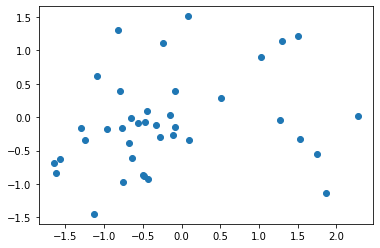

In [21]:
species_combining_matrix = mixed_species_model.alchemical.combining_matrix.detach().numpy()

plt.scatter(species_combining_matrix[:, 0], species_combining_matrix[:, 1])